In [119]:
# http

#### CBOE CNDR Replica
```
Below is an attempt to replicate the CBOE's CNDR index
based on the implementation described in their white paper.

http://www.cboe.com/index/dashboard/cndr#cndr-overview
https://www.cboe.com/publish/micropdf/CBOE-SP500-Iron-Condor-CNDR-Methodology-Paper.pdf

deviations:

+ option prices are replaced with estimated price using BSM.
+ sigma in BSM is just average of realized and implied vol
+ underlying price is also estimated using open close price.
+ roll date is every first business day, assuming next set of contracts expire on the first business day next month.
+ strike at .2 and .05 delta not used instead using 1sd and 2sd based on rolling 21-day price return sd.

```

In [120]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from py_vollib.ref_python.black_scholes_merton import black_scholes_merton

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [121]:
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
start_date = '1980-1-1'
future_date = datetime.datetime.now().date()+datetime.timedelta(days=45)
end_date = future_date.strftime('%Y-%m-%d')
print(start_date,end_date)

1980-1-1 2021-01-21


In [122]:
def get_business_day(date):
    while date.isoweekday() > 5 or date in cal.holidays():
        date += dt.timedelta(days=1)
    return date

first_bday_of_month = [get_business_day(d).date() for d in pd.date_range(start_date, end_date, freq='BMS')]

In [123]:
# download and read CNDR index from CBOE website
cndr = pd.read_csv('static/CNDR_Data.csv')
cndr.index=[datetime.datetime.strptime(x,'%m/%d/%Y').date() for x in cndr.time]
cndr=cndr.drop(columns=['time','volume','open','high','low'])
cndr=cndr.rename(columns={'close':'cndr'})

In [124]:
cndr.head()

,cndr
1986-06-20,100.0
1986-06-23,100.0
1986-06-24,100.0
1986-06-25,100.0
1986-06-26,100.0


In [125]:
def get_df():
    # get historical daily price for SPY
    symbol = '^VIX'
    tick = yf.Ticker(symbol)
    vix_history = tick.history(period="max")
    vix_history = vix_history.drop(
        columns=['Open','High','Low','Volume','Dividends','Stock Splits']
    )
    vix_history = vix_history.rename(columns={'Close':'implied_vol'})

    symbol = '^IRX'# 13 Week Treasury Bill
    tick = yf.Ticker(symbol)
    tbill_history = tick.history(period="max")
    tbill_history = tbill_history.drop(
        columns=['Open','High','Low','Volume','Dividends','Stock Splits']
    )
    tbill_history = tbill_history.rename(columns={'Close':'deannualized_interest_rate'})
    tbill_history = tbill_history*0.01/365

    symbol = 'SPY'
    tick = yf.Ticker(symbol)
    ticker_history = tick.history(period="max")
    df = pd.merge(
        ticker_history,vix_history,
        how='left',left_index=True,right_index=True)
    df = pd.merge(
        df,tbill_history,
        how='left',left_index=True,right_index=True)

    df['close']=df.Close
    df['open']=df.Open
    df=df.drop(columns=['Open','High','Low','Close','Volume','Dividends','Stock Splits'])
    df['ret']= np.log(df.close).diff(1)
    df['realized_vol'] = df.ret.rolling(21).std()*np.sqrt(252)*100

    df['ret21d']= df.close.pct_change(21)
    df['ret21d_sd'] = df.ret21d.rolling(21).std()
    df['ret21d_mean'] = df.ret21d.rolling(21).mean()

    df = df.dropna()

    # add in placeholders
    df['expiry_date']=''
    df['p1sd_strike']=np.nan
    df['m1sd_strike']=np.nan
    df['p2sd_strike']=np.nan
    df['m2sd_strike']=np.nan
    df['cost']=np.nan
    df['cash']=np.nan
    df['r']=np.nan
    return df.copy()

In [126]:
df = get_df()
df.head()

,implied_vol,deannualized_interest_rate,close,open,ret,realized_vol,ret21d,ret21d_sd,ret21d_mean,expiry_date,p1sd_strike,m1sd_strike,p2sd_strike,m2sd_strike,cost,cash,r
Date,,,,,,,,,,,,,,,,,
1993-03-30,12.23,0.000080,26.966932,26.929659,0.002769,11.737076,0.025995,0.011409,0.021879,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-03-31,12.53,0.000079,26.948282,27.041464,-0.000692,10.671005,0.010313,0.011681,0.021286,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-01,13.02,0.000079,26.855091,26.985546,-0.003464,10.667118,0.002635,0.012370,0.020470,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-02,14.50,0.000080,26.296005,26.631461,-0.021038,12.834246,-0.012769,0.014255,0.019291,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-05,14.12,0.000079,26.426460,26.501006,0.004949,12.948246,-0.005099,0.014544,0.019115,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
def compute_cost(rows,open=False,ind=-1):

    today = rows.index[-1].date()
    
    expiry_date = rows.expiry_date.values[ind]
    p1sd_strike=rows.p1sd_strike.values[ind]
    m1sd_strike=rows.m1sd_strike.values[ind]
    p2sd_strike=rows.p2sd_strike.values[ind]
    m2sd_strike=rows.m2sd_strike.values[ind]
    
    volatility = np.mean([rows.realized_vol.values[-1],rows.implied_vol.values[-1]])
    sigma = volatility/100
    
    if open:
        # weighting the open price more to simulate purchasing in morning.
        underlying_price = (rows.open.values[-1]*4+rows.close.values[-1])/5
    else:
        underlying_price = (rows.open.values[-1]+rows.close.values[-1]*4)/5
    
    dte = (expiry_date-today).days
    time_to_expiry_years = dte/365

    S = underlying_price
    K = p1sd_strike
    q = 0
    t = time_to_expiry_years
    r = 0
    sigma = sigma
    call_1sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)

    S = underlying_price
    K = m1sd_strike
    q = 0
    t = time_to_expiry_years
    r = 0
    sigma = sigma
    put_1sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)

    S = underlying_price
    K = p2sd_strike
    q = 0
    t = time_to_expiry_years
    r = 0
    sigma = sigma
    call_2sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)

    S = underlying_price
    K = m2sd_strike
    q = 0
    t = time_to_expiry_years
    r = 0
    sigma = sigma
    put_2sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)

    #call_1sd_price,put_1sd_price,call_2sd_price,put_2sd_price
    cost = put_2sd_price-put_1sd_price-call_1sd_price+call_2sd_price
    
    max_loss = np.max([p2sd_strike-p1sd_strike,m1sd_strike-m2sd_strike])
    
    return cost,max_loss

def myfunc(ser):
    # mark date to be roll date.
    # also set the strikes to purchase to setup iron condor.
    rows = df.loc[ser.index]
    
    today = rows.index[-1].date()
    index = rows.index[-1]
    
    roll = False
    
    # first trade or roll day
    expiry_date = rows.expiry_date.values[0]
    
    if expiry_date == '' or today in first_bday_of_month:
        roll = True

    r1, r2 = 1, 1
    #print(expiry_date,roll,today)
    if roll is False:
        
        # get info from yesterday
        yesterday_index = ser.index[-2]
        yesterday_cost = df.at[yesterday_index,'cost']
        yesterday_cash = df.at[yesterday_index,'cash']
        interest_rate = df.at[yesterday_index,'deannualized_interest_rate']
        
        # document
        df.at[index,'expiry_date']=df.at[yesterday_index,'expiry_date']
        df.at[index,'p1sd_strike']=df.at[yesterday_index,'p1sd_strike']
        df.at[index,'m1sd_strike']=df.at[yesterday_index,'m1sd_strike']
        df.at[index,'p2sd_strike']=df.at[yesterday_index,'p2sd_strike']
        df.at[index,'m2sd_strike']=df.at[yesterday_index,'m2sd_strike']

        # compute today's info
        cash = yesterday_cash*(1+interest_rate)
        cost, max_loss = compute_cost(rows,open=False,ind=0)
        df.at[index,'cost']=cost
        df.at[index,'cash']=cash
        
        r1=(yesterday_cash+yesterday_cost)/(cash+cost)
        
    if roll:
        
        contract_dates = np.array(first_bday_of_month)
        new_contract_index = np.argmin(np.abs([x.days for x in contract_dates-today]))
        expiry_date = contract_dates[new_contract_index+1]
        
        dte = (expiry_date-today).days
        ret_mean = rows.ret21d_mean.values[-1]
        ret_sd = rows.ret21d_sd.values[-1]        

        # http://www.cboe.com/index/dashboard/cndr
        underlying_price = rows.close.values[-1]
        p1sd_strike = underlying_price*(1+ret_mean+0.7*ret_sd) # 1sd ~ 16 delta
        m1sd_strike = underlying_price*(1+ret_mean+0.7*ret_sd)
        p2sd_strike = underlying_price*(1+ret_mean-2*ret_sd) # 2sd ~ 5? delta
        m2sd_strike = underlying_price*(1+ret_mean-2*ret_sd)

        df.at[index,'expiry_date']=expiry_date
        df.at[index,'p1sd_strike']=p1sd_strike
        df.at[index,'m1sd_strike']=m1sd_strike
        df.at[index,'p2sd_strike']=p2sd_strike
        df.at[index,'m2sd_strike']=m2sd_strike
        
        rows.expiry_date=expiry_date
        rows.p1sd_strike=p1sd_strike
        rows.m1sd_strike=m1sd_strike
        rows.p2sd_strike=p2sd_strike
        rows.m2sd_strike=m2sd_strike
        
        open_cost, open_max_loss = compute_cost(rows,open=True)
        cash = open_max_loss*10
        cost, max_loss = compute_cost(rows,open=False)
        
        r2 = (cash+cost)/(cash+open_cost)
        
        df.at[index,'cost']=cost
        df.at[index,'cash']=cash
        #print('roll')
    r = (1-r1*r2)
    
    # out of stem here....
    # added this as "easy and bad" way to match with CNDR.
    if r > 0: 
        r*=.9
    else:
        r*=1.1
        
    df.at[index,'r']=r
    #print(r1,r2)
    return 0 # must return value

df = get_df()
df = df.iloc[-252*2:,:].copy()
#df = df.iloc[-252*5:,:].copy()
#df = df.iloc[-252*10:,:].copy()
rol = df.close.rolling(window=2)
_=rol.apply(myfunc, raw=False)
df = df.dropna()

In [242]:
mdf = pd.merge(df,cndr,how='left',left_index=True,right_index=True)

In [243]:
mdf.head()

,implied_vol,deannualized_interest_rate,close,open,ret,realized_vol,ret21d,ret21d_sd,ret21d_mean,expiry_date,p1sd_strike,m1sd_strike,p2sd_strike,m2sd_strike,cost,cash,r,cndr
Date,,,,,,,,,,,,,,,,,,
2018-11-29,18.790001,0.000063,263.545166,263.285430,-0.002187,18.988825,0.023192,0.030002,-0.019764,2019-01-02,263.871269,263.871269,242.522899,242.522899,9.820106,213.483694,-0.000658,748.82
2018-11-30,18.070000,0.000063,265.151550,263.381632,0.006077,18.765202,0.018549,0.028614,-0.015462,2019-01-02,263.871269,263.871269,242.522899,242.522899,11.245834,213.497204,0.005764,748.45
2018-12-03,16.440001,0.000063,268.662476,269.605162,0.013154,18.952839,0.021169,0.027549,-0.011482,2019-01-02,270.758750,270.758750,250.775111,250.775111,8.076803,199.836394,0.002242,NaN
2018-12-04,20.740000,0.000065,259.957214,267.767950,-0.032939,22.223463,-0.006032,0.025150,-0.008881,2019-01-02,270.758750,270.758750,250.775111,250.775111,0.315834,199.848921,-0.042581,749.35
2018-12-06,21.190001,0.000064,259.562805,255.792120,-0.001518,22.125859,-0.012985,0.023345,-0.007112,2019-01-02,270.758750,270.758750,250.775111,250.775111,-2.277311,199.861870,-0.014365,750.21


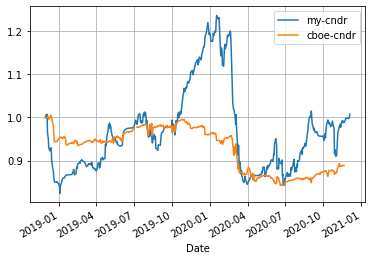

In [244]:
(1+np.cumsum(mdf.r)).plot(label='my-cndr')
(mdf.cndr/mdf.cndr.iloc[0]).plot(label='cboe-cndr')
plt.legend()
plt.grid(True)